In [ ]:
!pip install torch
!pip install librosa

In [ ]:
from pathlib import Path
import os
import pandas as pd
import librosa
import re
import matplotlib.pyplot as plt
import numpy as np
#from scipy.signal import butter, sosfiltfilt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

import cv2

## tqdm for loading bars
from tqdm.notebook import tqdm

import tensorflow as tf

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

## Torchvision
import torchvision
from torchvision import transforms
from torchvision import models

from torchsummary import summary

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#ensure reproducibility on gpu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Unibo/ai_in_industry/images/chromagrams/"

image_names = os.listdir(path)

n_chroma = len(image_names)

In [ ]:
batch_size = 64
y_dim = 12
x_dim = 474

steps = n_chroma//batch_size

generator that is used instead of a dataloader in order to avoid exceeding the ram capacity

In [ ]:
# Make this an infinite generator
def gen(img_names):

  while True:

    i = 0
    images = np.zeros((batch_size,y_dim,x_dim), dtype=np.float64)

    while i < len(img_names):
      complete_path = path + img_names[i]

      images[i%batch_size,:,:] = cv2.imread(complete_path, cv2.IMREAD_GRAYSCALE)[:y_dim,:x_dim]/255
      i += 1
      if i%batch_size == 0:
        images = images.reshape(batch_size, y_dim, x_dim, 1)
        yield (images)
        images = np.zeros((batch_size,y_dim,x_dim))

In [ ]:
class IterDataset(data.IterableDataset):
    def __init__(self, generator):
        self.generator = generator

    def __iter__(self):
        return self.generator()

In [ ]:
images_gen = gen(image_names)

transformation function and data loader

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                transforms.RandomAffine(degrees=0, translate=(0.1,0)),
                                transforms.RandomErasing(p=0.4, scale=(0.02, 0.03), ratio=(0.2,0.3), value=0.6, inplace=False),  
                                transforms.RandomErasing(p=0.4, scale=(0.02, 0.1), ratio=(0.02,0.05), value=0.9, inplace=False)
                               ])

"for index, img in enumerate(train_dataloader):\n    print(img.shape)\n    plt.imshow(img[0].permute(1, 2, 0)[:, :, 0], aspect = 'auto')\n    plt.show()"

In [ ]:
train_generator = IterDataset(images_gen) 

train_dataloader = torch.utils.data.DataLoader(train_generator)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class SimCLRModel(nn.Module):
    def __init__(self):
      super(SimCLRModel, self).__init__()
      self.resnet = torchvision.models.resnet50(weights=None)  #maybe we could use some already existing weights
      
      #self.resnet = ResNet(models.resnet.Bottleneck, [3, 8, 36, 3], pretrained = False)    #if we want to use a 1d tensor, but it might be easier to just paste it three times onto a 3d tensor
      #self.avgpool = torch.nn.AvgPool2d()   #it flattens one dimension? if that's it we already have a 2d array
      self.fc1 = nn.Linear(1000, 256)   #not sure about 1000
      self.fc2 = nn.Linear(256, 128)
      self.fc3 = nn.Linear(128, 50)
      self.relu = nn.ReLU()

    def forward(self, x):
      x = self.resnet(x)
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      x = self.relu(x)
      x = self.fc3(x)
      return x

In [ ]:
model = SimCLRModel()
model = model.to(device)

In [ ]:
summary(model, (3, 12, 474))

loss function

In [ ]:
negative_mask = np.ones((BATCH_SIZE, 2 * BATCH_SIZE), dtype=bool)
for i in range(BATCH_SIZE):
    negative_mask[i, i] = 0
    negative_mask[i, i + BATCH_SIZE] = 0
negative_mask = torch.from_numpy(negative_mask).to(device)

def loss_fn(xis, xjs, model, optimizer, criterion, temperature):
  optimizer.zero_grad()

  xis = xis.to(device)
  xjs = xjs.to(device)
  xis = xis.float()
  xjs = xjs.float()

  zis = model(xis)
  zjs = model(xjs)

  zis = torch.nn.functional.normalize(zis, p=2, dim=1)
  zjs = torch.nn.functional.normalize(zjs, p=2, dim=1)

  l_pos = torch.matmul(torch.unsqueeze(zis, 1), torch.unsqueeze(zis, 2))
  l_pos = torch.reshape(l_pos, (BATCH_SIZE, 1))
  l_pos = l_pos / temperature

  negatives = torch.cat([zjs, zis], axis=0)

  loss = 0

  for positives in [zis, zjs]:
    
      cosine_sim_2d = torch.nn.CosineSimilarity(dim=2, eps=1e-08)
      l_neg = cosine_sim_2d(torch.unsqueeze(positives, 1), torch.unsqueeze(negatives, 0))

      labels = torch.zeros(BATCH_SIZE, dtype=torch.int32).type(torch.LongTensor).to(device)

      l_neg = torch.masked_select(l_neg, negative_mask)
      l_neg = torch.reshape(l_neg, (BATCH_SIZE, -1))
      l_neg = l_neg / temperature

      logits = torch.cat([l_pos, l_neg], axis=1)
      loss += criterion(input=logits, target=labels)

  loss = loss / (2 * BATCH_SIZE)

  loss.backward()
  optimizer.step()

  return loss

training function

In [ ]:
def train_simclr(model, dataloader, optimizer, criterion,
                 temperature=0.1, epochs=3):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        #for image_batch in dataloader:
        for i in tqdm(range(steps)):
            #print(i, "/", steps)
            image_batch = next(images_gen)
            a = transforms.Lambda(lambda x: torch.stack([transform(x_) for x_ in x]))(image_batch)
            b = transforms.Lambda(lambda x: torch.stack([transform(x_) for x_ in x]))(image_batch)

            loss = loss_fn(a, b, model, optimizer, criterion, temperature).item()
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))    #does the mean make sense. find out in the next episode
        
        print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

run the training

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

epoch: 1 loss: 0.029


  0%|          | 0/82 [00:00<?, ?it/s]

epoch: 2 loss: 0.019


  0%|          | 0/82 [00:00<?, ?it/s]

epoch: 3 loss: 0.015


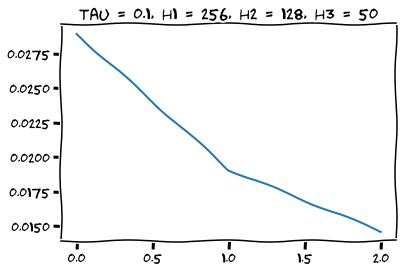

In [ ]:
LEARNING_RATE = 1e-3

criterion = torch.nn.CrossEntropyLoss()

#decay_steps = 1000
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#MAYBE USE ADAMW BUT IT SHOULDN'T MAKE A BIG DIFFERENCE
optimizerW = optim.AdamW(model.parameters(), lr=LEARNING_RATE, decay_steps = 1000)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=LEARNING_RATE/50) #t_max = max_epochs

epoch_wise_loss, model_trained  = train_simclr(model, train_dataloader, optimizer, criterion,
                 temperature=0.1, epochs=3)


plt.plot(epoch_wise_loss)
plt.show()

here we do the encoding on the test. Test is the set of the original images, without augmentation

In [ ]:
transform_test = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1, 1))])

# empty numpy array, we want to append to an empty list basically
all_features = np.array([]).reshape((0,50))

for i in tqdm(range(steps)):
  batch = next(images_gen).reshape((batch_size,y_dim,x_dim))
  test = transform_test(batch)
  test = test.permute((2, 0, 3, 1)).to(device).float()

  features = model(test)

  features = features.detach().cpu().numpy()

  all_features = np.concatenate( (all_features, features) )

print(all_features.shape)

  0%|          | 0/82 [00:00<?, ?it/s]

(5248, 50)


clustering

In [ ]:
from sklearn.metrics import calinski_harabasz_score

cluster_number = range(2,120)  #(2,240,5) 

distortions = []
silhouette_scores = []
calinski_harabasz_scores = []
for n in cluster_number:
    print(n, end=' ')
    estimator = KMeans(n_clusters = n, init='k-means++', n_init=10, max_iter=300)
    y = estimator.fit_predict(all_features)
    distortions.append(estimator.inertia_)
    silhouette_scores.append(silhouette_score(all_features,y))
    calinski_harabasz_scores.append(calinski_harabasz_score(all_features,y))
print()

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


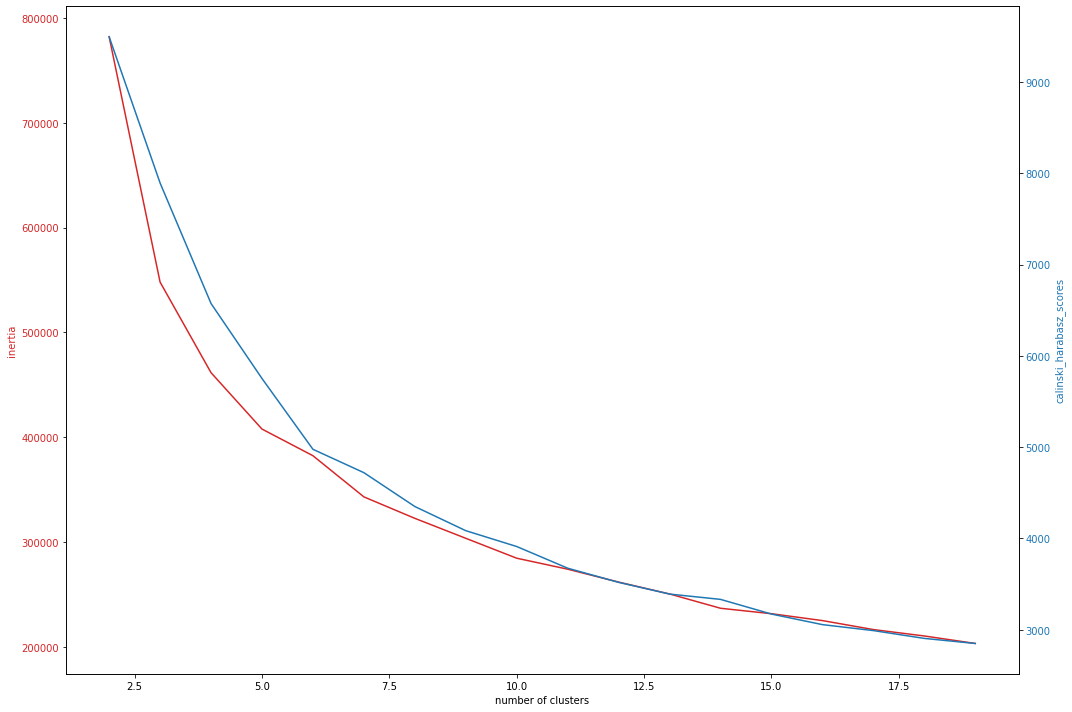

(50,)


In [ ]:
t = cluster_number
data1 = distortions
data2 = silhouette_scores #calinski_harabasz_scores 

fig, ax1 = plt.subplots(figsize = (15, 10))
          
color = 'tab:red'
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('inertia', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('calinski_harabasz_scores', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim(-0.03,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()
print(features[0].shape)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def plot_clusters(X, y, dim, points=None,
                  labels_prefix = 'cluster', 
                  points_name = 'centroids',
                  colors = cm.tab10, # a qualitative map 
                      # https://matplotlib.org/examples/color/colormaps_reference.html
#                   colors = ['brown', 'orange', 'olive', 
#                             'green', 'cyan', 'blue', 
#                             'purple', 'pink'],
#                   points_color = 'red'
                  points_color = cm.tab10(10), # by default the last of the map (to be improved)
                  dbscan = False):
    """
    Plot a two dimensional projection of an array of labelled points
    X:      array with at least two columns
    y:      vector of labels, length as number of rows in X
    dim:    the two columns to project, inside range of X columns, e.g. (0,1)
    points: additional points to plot as 'stars'
    labels_prefix: prefix to the labels for the legend ['cluster']
    points_name:   legend name for the additional points ['centroids']
    colors: a color map
    points_color: the color for the points
    """
    # plot the labelled (colored) dataset and the points
    labels = np.unique(y)
    for i in range(len(labels)):
        color = colors(i / len(labels)) # choose a color from the map
        plt.scatter(X[y==labels[i],dim[0]], 
                    X[y==labels[i],dim[1]], 
                    s=10, 
                    c = [color], # scatter requires a sequence of colors
                    marker='s', 
                    label=labels_prefix+str(labels[i]))
    if dbscan == False:
        plt.scatter(points[:,dim[0]], points[:,dim[1]], s=50, marker='*', c=[points_color], label=points_name)
    plt.legend()
    plt.grid()
    plt.show() 

kmeans

In [ ]:
good_k = 15

estimator = KMeans(n_clusters = good_k, init='k-means++', n_init=10, max_iter=300,)
y = estimator.fit_predict(features)

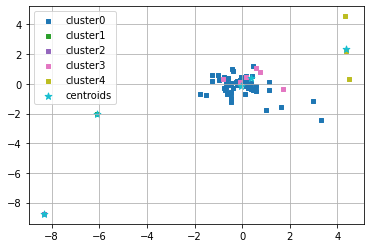

In [ ]:
plot_clusters(features, y, dim= (0,1), points= estimator.cluster_centers_)

dbscan

In [ ]:
from sklearn.cluster import DBSCAN

#definition of the dbscan model
db_model = DBSCAN(eps=0.05, min_samples=10) 
y_pred = db_model.fit_predict(pca_chromagrams) #dbscan predictions

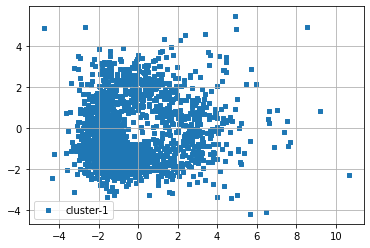

In [ ]:
plot_clusters(X, y_pred, dim= (0,1), dbscan = True)